<a href="https://colab.research.google.com/github/abrahamt-e/facial_recogniton_ck-/blob/main/facial_recognition_correct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ===================== 1. Upload and Extract ZIP =====================
from google.colab import files
import zipfile
import os

# Upload manually from your Downloads folder
uploaded = files.upload()  # upload `archive.zip` here

# Extract it
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("ck_dataset")

# Check files
print("Extracted files:", os.listdir("ck_dataset"))

# ===================== 2. Install & Import Libraries =====================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ===================== 3. Dataset Loading =====================
df = pd.read_csv("ck_dataset/ckextended.csv")
df = df[df["emotion"].isin(range(8))]  # Ensure only 8 emotions

class FERDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        pixels = np.fromstring(row['pixels'], dtype=int, sep=' ').reshape(48, 48)
        image = torch.tensor(pixels, dtype=torch.float32).unsqueeze(0) / 255.0
        label = int(row['emotion'])
        return image, label

train_df = df[df['Usage'] == "Training"]
val_df = df[df['Usage'] == "PublicTest"]

train_dataset = FERDataset(train_df)
val_dataset = FERDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ===================== 4. CNN Model =====================
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 24x24

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 6x6
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*6*6, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 8)  # 8 emotion classes
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# ===================== 5. Train the Model =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def evaluate(loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item()
            preds = torch.argmax(out, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total * 100
    return loss_sum / len(loader), acc

# ===================== 6. Run Training =====================
for epoch in range(10):
    model.train()
    total, correct, loss_sum = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/10")
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        preds = torch.argmax(out, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        loop.set_postfix(loss=loss_sum/(total/64), acc=correct/total*100)

    val_loss, val_acc = evaluate(val_loader)
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Saving archive.zip to archive (1).zip
Extracted files: ['ckextended.csv']


Epoch 1/10: 100%|██████████| 12/12 [00:04<00:00,  2.42it/s, acc=50, loss=2.47]


Val Loss: 1.7915, Val Acc: 64.84%


Epoch 2/10: 100%|██████████| 12/12 [00:04<00:00,  2.41it/s, acc=64.6, loss=1.39]


Val Loss: 1.6585, Val Acc: 64.84%


Epoch 3/10: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s, acc=66.3, loss=1.16]


Val Loss: 1.5815, Val Acc: 65.93%


Epoch 4/10: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s, acc=73.3, loss=1.01]


Val Loss: 1.3965, Val Acc: 68.13%


Epoch 5/10: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s, acc=79.3, loss=0.792]


Val Loss: 1.2484, Val Acc: 75.82%


Epoch 6/10: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s, acc=81.7, loss=0.688]


Val Loss: 1.0799, Val Acc: 79.12%


Epoch 7/10: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s, acc=84.6, loss=0.604]


Val Loss: 0.9184, Val Acc: 84.62%


Epoch 8/10: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s, acc=86.8, loss=0.451]


Val Loss: 1.0638, Val Acc: 84.62%


Epoch 9/10: 100%|██████████| 12/12 [00:04<00:00,  2.47it/s, acc=88.3, loss=0.395]


Val Loss: 0.9164, Val Acc: 86.81%


Epoch 10/10: 100%|██████████| 12/12 [00:04<00:00,  2.55it/s, acc=89.9, loss=0.325]


Val Loss: 0.8626, Val Acc: 85.71%


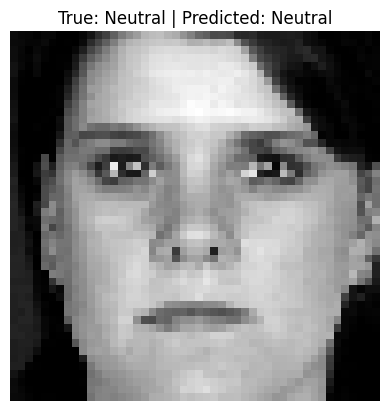

In [6]:
import matplotlib.pyplot as plt
import torch

# Map labels to emotion names
emotion_dict = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral",
    7: "Contempt"
}

def test_and_show_image(model, dataset, idx, device):
    model.eval()
    image, true_label = dataset[idx]

    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # Add batch dimension and send to device
        output = model(x)
        pred_label = torch.argmax(output, dim=1).item()

    # Plot image
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title(f"True: {emotion_dict[true_label]} | Predicted: {emotion_dict[pred_label]}")
    plt.axis('off')
    plt.show()

# Example usage:
# Replace val_dataset with your dataset and 'model' with your trained model.
# Make sure 'device' is defined (cpu or cuda)
test_index = 0  # pick any index you want to test
test_and_show_image(model, val_dataset, test_index, device)


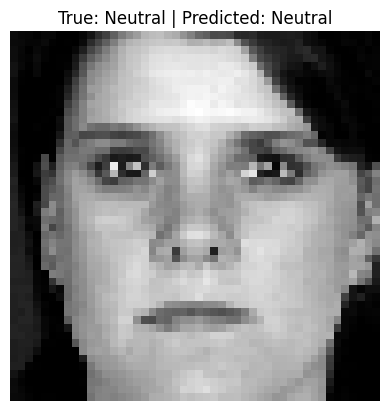

In [7]:
import matplotlib.pyplot as plt
import torch

# Map labels to emotion names
emotion_dict = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral",
    7: "Contempt"
}

def test_and_show_image(model, dataset, idx, device):
    model.eval()
    image, true_label = dataset[idx]

    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # Add batch dimension and send to device
        output = model(x)
        pred_label = torch.argmax(output, dim=1).item()

    # Plot image
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title(f"True: {emotion_dict[true_label]} | Predicted: {emotion_dict[pred_label]}")
    plt.axis('off')
    plt.show()

# Example usage:
# Replace val_dataset with your dataset and 'model' with your trained model.
# Make sure 'device' is defined (cpu or cuda)
test_index = 0  # pick any index you want to test
test_and_show_image(model, val_dataset, test_index, device)


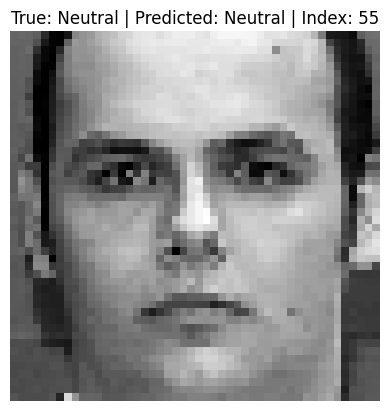

In [8]:
import matplotlib.pyplot as plt
import torch
import random

# Map labels to emotion names
emotion_dict = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral",
    7: "Contempt"
}

def test_and_show_random_image(model, dataset, device):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)  # Pick random index
    image, true_label = dataset[idx]

    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # Add batch dim, send to device
        output = model(x)
        pred_label = torch.argmax(output, dim=1).item()

    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title(f"True: {emotion_dict[true_label]} | Predicted: {emotion_dict[pred_label]} | Index: {idx}")
    plt.axis('off')
    plt.show()

# Example usage:
test_and_show_random_image(model, val_dataset, device)


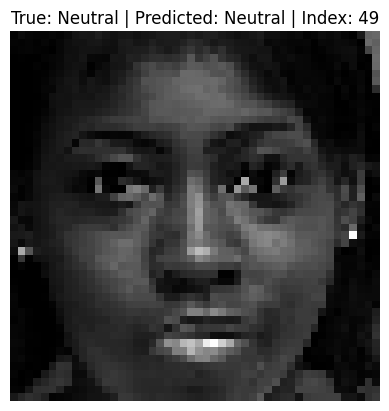

In [9]:
import matplotlib.pyplot as plt
import torch
import random

# Map labels to emotion names
emotion_dict = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral",
    7: "Contempt"
}

def test_and_show_random_image(model, dataset, device):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)  # Pick random index
    image, true_label = dataset[idx]

    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # Add batch dim, send to device
        output = model(x)
        pred_label = torch.argmax(output, dim=1).item()

    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title(f"True: {emotion_dict[true_label]} | Predicted: {emotion_dict[pred_label]} | Index: {idx}")
    plt.axis('off')
    plt.show()

# Example usage:
test_and_show_random_image(model, val_dataset, device)


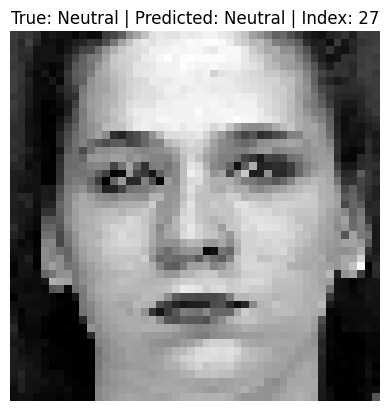

In [10]:
import matplotlib.pyplot as plt
import torch
import random

# Map labels to emotion names
emotion_dict = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral",
    7: "Contempt"
}

def test_and_show_random_image(model, dataset, device):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)  # Pick random index
    image, true_label = dataset[idx]

    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # Add batch dim, send to device
        output = model(x)
        pred_label = torch.argmax(output, dim=1).item()

    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title(f"True: {emotion_dict[true_label]} | Predicted: {emotion_dict[pred_label]} | Index: {idx}")
    plt.axis('off')
    plt.show()

# Example usage:
test_and_show_random_image(model, val_dataset, device)


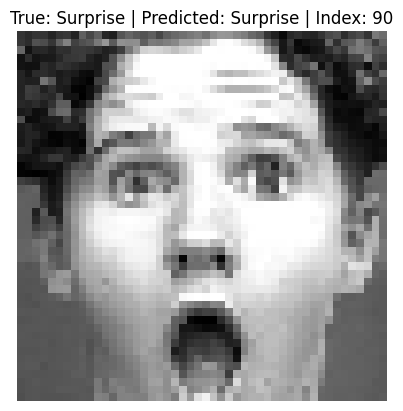

In [11]:
import matplotlib.pyplot as plt
import torch
import random

# Map labels to emotion names
emotion_dict = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral",
    7: "Contempt"
}

def test_and_show_random_image(model, dataset, device):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)  # Pick random index
    image, true_label = dataset[idx]

    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  # Add batch dim, send to device
        output = model(x)
        pred_label = torch.argmax(output, dim=1).item()

    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title(f"True: {emotion_dict[true_label]} | Predicted: {emotion_dict[pred_label]} | Index: {idx}")
    plt.axis('off')
    plt.show()

# Example usage:
test_and_show_random_image(model, val_dataset, device)
